In [2]:
import numpy as np
from qiskit import *
from qiskit.circuit import Gate

In [3]:
my_gate = Gate(name='my_gate',num_qubits=2,params=[])

In [6]:
qr = QuantumRegister(3,'q')
circ = QuantumCircuit(qr)
circ.append(my_gate,[qr[0],qr[1]])
circ.append(my_gate,[qr[1],qr[2]])
circ.draw()

┌──────────┐            
q_0: ┤0         ├────────────
     │  my_gate │┌──────────┐
q_1: ┤1         ├┤0         ├
     └──────────┘│  my_gate │
q_2: ────────────┤1         ├
                 └──────────┘

In [7]:
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1, 2, -2, sub_q[0])
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw()

┌───┐                       
q_0: ┤ H ├──■────────────────────
     └───┘┌─┴─┐     ┌───────────┐
q_1: ─────┤ X ├──■──┤0          ├
          └───┘┌─┴─┐│  sub_circ │
q_2: ──────────┤ X ├┤1          ├
               └───┘└───────────┘

In [8]:
decomposed_circ = circ.decompose()
decomposed_circ.draw()

┌─────────┐                                        
q_0: ┤ U2(0,π) ├──■─────────────────────────────────────
     └─────────┘┌─┴─┐     ┌───┐          ░ ┌───────────┐
q_1: ───────────┤ X ├──■──┤ H ├────■─────░─┤ U(1,2,-2) ├
                └───┘┌─┴─┐└───┘┌───┴───┐ ░ └───┬───┬───┘
q_2: ────────────────┤ X ├─────┤ Rz(1) ├─░─────┤ I ├────
                     └───┘     └───────┘ ░     └───┘

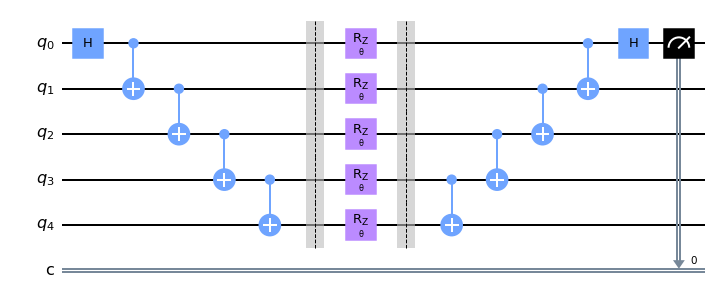

In [10]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5,1)

qc.h(0)
for i in range(n-1):
    qc.cx(i,i+1)
qc.barrier()
qc.rz(theta,range(5))
qc.barrier()
for i in reversed(range(n-1)):
    qc.cx(i,i+1)
qc.h(0)
qc.measure(0,0)
qc.draw('mpl')

In [11]:
print(qc.parameters)

ParameterView([Parameter(θ)])


In [14]:
import numpy as np

theta_range = np.linspace(0,2*np.pi,128)

circuits = [qc.bind_parameters({theta: theta_val}) for theta_val in theta_range]

circuits[-1].draw()

┌───┐                     ░ ┌────────┐ ░                     ┌───┐┌─┐
q_0: ┤ H ├──■──────────────────░─┤ Rz(2π) ├─░──────────────────■──┤ H ├┤M├
     └───┘┌─┴─┐                ░ ├────────┤ ░                ┌─┴─┐└───┘└╥┘
q_1: ─────┤ X ├──■─────────────░─┤ Rz(2π) ├─░─────────────■──┤ X ├──────╫─
          └───┘┌─┴─┐           ░ ├────────┤ ░           ┌─┴─┐└───┘      ║ 
q_2: ──────────┤ X ├──■────────░─┤ Rz(2π) ├─░────────■──┤ X ├───────────╫─
               └───┘┌─┴─┐      ░ ├────────┤ ░      ┌─┴─┐└───┘           ║ 
q_3: ───────────────┤ X ├──■───░─┤ Rz(2π) ├─░───■──┤ X ├────────────────╫─
                    └───┘┌─┴─┐ ░ ├────────┤ ░ ┌─┴─┐└───┘                ║ 
q_4: ────────────────────┤ X ├─░─┤ Rz(2π) ├─░─┤ X ├─────────────────────╫─
                         └───┘ ░ └────────┘ ░ └───┘                     ║ 
c: 1/═══════════════════════════════════════════════════════════════════╩═
                                                                        0

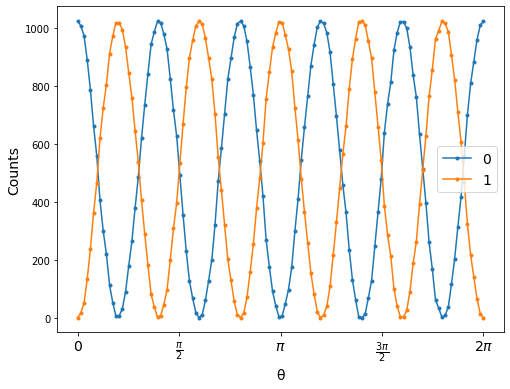

In [16]:
import matplotlib.pyplot as plt
backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)